In [96]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

Variational Quantum Thermalizer
===============================

::: {.meta}
:property=\"og:description\": Using the Variational Quantum Thermalizer
to prepare the thermal state of a Heisenberg model Hamiltonian.
:property=\"og:image\":
<https://pennylane.ai/qml/_images/thumbnail_vqt.png>
:::

::: {.related}
tutorial\_vqe Variational quantum eigensolver
:::

*Author: Jack Ceroni --- Posted: 7 July 2020. Last updated: 28 January
2021.*

This demonstration discusses theory and experiments relating to a
recently proposed quantum algorithm called the [Variational Quantum
Thermalizer](https://arxiv.org/abs/1910.02071) (VQT): a generalization
of the well-know
`Variational Quantum Eigensolver </demos/tutorial_vqe>`{.interpreted-text
role="doc"} (VQE) to systems with non-zero temperatures.


The Idea
========


The goal of the VQT is to prepare the [thermal
state](https://en.wikipedia.org/wiki/KMS_state) of a given Hamiltonian
$\hat{H}$ at temperature $T$, which is defined as

$$\rho_\text{thermal} \ = \ \frac{e^{- \hat{H} \beta}}{\text{Tr}(e^{- \hat{H} \beta})} \ = \ \frac{e^{- \hat{H} \beta}}{Z_{\beta}},$$

where $\beta \ = \ 1/T$. The thermal state is a [mixed
state](https://en.wikipedia.org/wiki/Quantum_state#Mixed_states), which
means that can be described by an ensemble of pure states. Since we are
attempting to learn a mixed state, we must deviate from the standard
variational method of passing a pure state through an ansatz circuit,
and minimizing the energy expectation.

The VQT begins with an initial [density
matrix](https://en.wikipedia.org/wiki/Density_matrix), $\rho_{\theta}$,
described by a probability distribution parametrized by some collection
of parameters $\theta$, and an ensemble of pure states,
$\{|\psi_i\rangle\}$. Let $p_i(\theta_i)$ be the probability
corresponding to the $i$-th pure state. We sample from this probability
distribution to get some pure state $|\psi_k\rangle$, which we pass
through a parametrized circuit, $U(\phi)$. From the results of this
circuit, we then calculate
$\langle \psi_k | U^{\dagger}(\phi) \hat{H}\, U(\phi) |\psi_k\rangle$.
Repeating this process multiple times and taking the average of these
expectation values gives us the the expectation value of $\hat{H}$ with
respect to $U \rho_{\theta} U^{\dagger}$.

![Inputted parameters create an initial density matrix and a
parametrized ansatz, which are used to calculate the expectation value
of the Hamiltonian with respect to a new mixed
state.](../demonstrations/vqt/ev.png){.align-center width="100.0%"}

Arguably, the most important part of a variational circuit is its cost
function, which we attempt to minimize with a classical optimizer. In
VQE, we generally try to minimize
$\langle \psi(\theta) | \hat{H} | \psi(\theta) \rangle$ which, upon
minimization, gives us a parametrized circuit that prepares a good
approximation to the ground state of $\hat{H}$. In the VQT, the goal is
to arrive at a parametrized probability distribution, and a parametrized
ansatz, that generate a good approximation to the thermal state. This
generally involves more than calculating the energy expectation value.
Luckily, we know that the thermal state of $\hat{H}$ minimizes the
following free-energy cost function

$$\mathcal{L}(\theta, \ \phi) \ = \ \beta \ \text{Tr}( \hat{H} \ \hat{U}(\phi) \rho_{\theta} \hat{U}(\phi)^{\dagger} ) \ - \ S_\theta,$$

where $S_{\theta}$ is the [von Neumann
entropy](https://en.wikipedia.org/wiki/Von_Neumann_entropy) of
$U \rho_{\theta} U^{\dagger}$, which is the same as the von Neumann
entropy of $\rho_{\theta}$ due to invariance of entropy under unitary
transformations. This cost function is minimized when
$\hat{U}(\phi) \rho_{\theta} \hat{U}(\phi)^{\dagger} \ = \ \rho_{\text{thermal}}$,
so similarly to VQE, we minimize it with a classical optimizer to obtain
the target parameters, and thus the target state.

![A high-level representation of how the VQT
works.](../demonstrations/vqt/vqt.png){.align-center width="80.0%"}

All together, the outlined processes give us a general protocol to
generate thermal states.


Simulating the VQT for a 4-Qubit Heisenberg Model
=================================================


In this demonstration, we simulate the 4-qubit Heisenberg model. We can
begin by importing the necessary dependencies.


In [97]:
import pennylane as qml
from matplotlib import pyplot as plt
import numpy as np
from numpy import array
import scipy
from scipy.optimize import minimize
import networkx as nx
import seaborn
import itertools
from numpy import savetxt

np.random.seed(42)

nr_qubits = 4

The Heisenberg Hamiltonian is defined as

$$\hat{H} \ = \ \displaystyle\sum_{(i, j) \in E} X_i X_j \ + \ Z_i Z_j \ + \ Y_i Y_j,$$

where $X_i$, $Y_i$ and $Z_i$ are the Pauli gates acting on the $i$-th
qubit. In addition, $E$ is the set of edges in the graph
$G \ = \ (V, \ E)$ describing the interactions between the qubits. In
this demonstration, we define the interaction graph to be the cycle
graph:


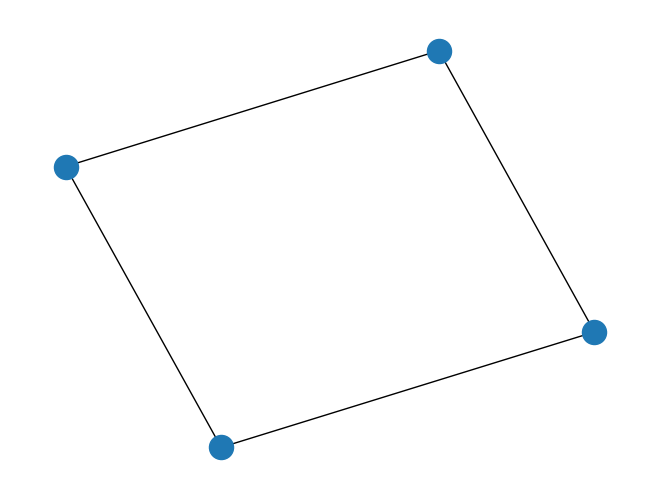

In [98]:
interaction_graph = nx.cycle_graph(nr_qubits)
# interaction_graph = nx.cycle_graph(4)
nx.draw(interaction_graph)

With this, we can calculate the matrix representation of the Heisenberg
Hamiltonian in the computational basis:


In [154]:
interaction_graph.edges


EdgeView([(0, 1), (0, 3), (1, 2), (2, 3)])

In [133]:
1 in (3,2)
qml.matrix(qml.PauliX)(0)

array([[0, 1],
       [1, 0]])

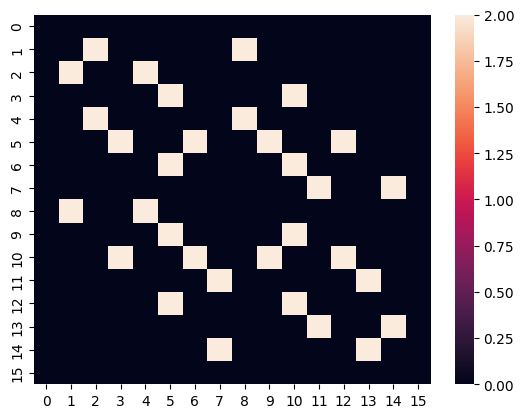

In [166]:
#수정사항! XY model로 변경하기 위해 Z 항들을 제거했습니다.

def create_hamiltonian_matrix(n, graph):
    matrix = np.zeros((2 ** n, 2 ** n))
    for i in graph.edges:
#         x = y = z = 1
        x = y = 1
        for j in range(0, n):
            if j == i[0] or j == i[1]:
                x = np.kron(x, qml.matrix(qml.PauliX)(0))
                y = np.kron(y, qml.matrix(qml.PauliY)(0))
#                 z = np.kron(z, qml.matrix(qml.PauliZ)(0))
            else:
                x = np.kron(x, np.identity(2))
                y = np.kron(y, np.identity(2))
#                 z = np.kron(z, np.identity(2))
        matrix = np.add(matrix, np.add(x, y))
#         matrix = np.add(matrix, np.add(x, np.add(y, z)))
    return matrix

ham_matrix = create_hamiltonian_matrix(nr_qubits, interaction_graph)

# Prints a visual representation of the Hamiltonian matrix
seaborn.heatmap(ham_matrix.real)
plt.show()

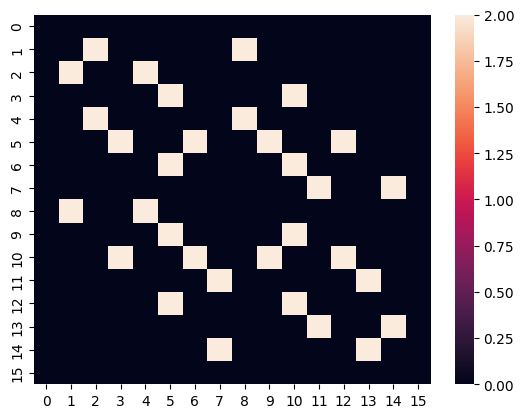

In [169]:
from qiskit.quantum_info import Pauli
Pauli_words = ['XXII', 'YYII', 'IXXI', 'IYYI', 'IIXX', 'IIYY', 'XIIX', 'YIIY']
# Pauli_words = ['XXII', 'YYII', 'IXXI', 'IYYI', 'IIXX', 'IIYY', 'XIIX', 'YIIY']+['ZIII', 'IZII', 'IIZI', 'IIIZ']
# Magnetization을 포함할 때 사용하는 코드

matrix = np.zeros((2 ** nr_qubits, 2 ** nr_qubits),dtype=complex)
for word in Pauli_words:
    matrix += Pauli.to_matrix(Pauli(word))
seaborn.heatmap(matrix.real)
plt.show()

The first step of the VQT is to create the initial density matrix,
$\rho_\theta$. In this demonstration, we let $\rho_\theta$ be
*factorized*, meaning that it can be written as an uncorrelated tensor
product of $4$ one-qubit density matrices that are diagonal in the
computational basis. The motivation is that in this factorized model,
the number of $\theta_i$ parameters needed to describe $\rho_\theta$
scales linearly rather than exponentially with the number of qubits. For
each one-qubit system described by $\rho_\theta^i$, we have

$$\rho_{\theta}^{i} \ = \ p_i(\theta_i) |0\rangle \langle 0| \ + \ (1 \ - \ p_i(\theta_i))|1\rangle \langle1|.$$

From here, all we have to do is define $p_i(\theta_i)$, which we choose
to be the sigmoid

$$p_{i}(\theta_{i}) \ = \ \frac{e^{\theta_i}}{e^{\theta_i} \ + \ 1}.$$


In [100]:
def sigmoid(x):
    return np.exp(x) / (np.exp(x) + 1)

This is a natural choice for probability function, as it has a range of
$[0, \ 1]$, meaning that we don't need to restrict the domain of
$\theta_i$ to some subset of the real numbers. With the probability
function defined, we can write a method that gives us the diagonal
elements of each one-qubit density matrix, for some parameters $\theta$:


In [101]:
def prob_dist(params):
    return np.vstack([sigmoid(params), 1 - sigmoid(params)]).T

Creating the Ansatz Circuit
===========================


With this done, we can move on to defining the ansatz circuit,
$U(\phi)$, composed of rotational and coupling layers. The rotation
layer is simply `RX`, `RY`, and `RZ` gates applied to each qubit. We
make use of the `AngleEmbedding` function, which allows us to easily
pass parameters into rotational layers.


In [102]:
def single_rotation(phi_params, qubits):

    rotations = ["Z", "Y", "X"]
    for i in range(0, len(rotations)):
        qml.AngleEmbedding(phi_params[i], wires=qubits, rotation=rotations[i])

To construct the general ansatz, we combine the method we have just
defined with a collection of parametrized coupling gates placed between
qubits that share an edge in the interaction graph. In addition, we
define the depth of the ansatz, and the device on which the simulations
are run:


In [103]:
depth = 4
dev = qml.device("default.qubit", wires=nr_qubits)


def quantum_circuit(rotation_params, coupling_params, sample=None):

    # Prepares the initial basis state corresponding to the sample
    qml.BasisStatePreparation(sample, wires=range(nr_qubits))

    # Prepares the variational ansatz for the circuit
    for i in range(0, depth):
        single_rotation(rotation_params[i], range(nr_qubits))
        qml.broadcast(
            unitary=qml.CRX,
            pattern="ring",
            wires=range(nr_qubits),
            parameters=coupling_params[i]
        )

    # Calculates the expectation value of the Hamiltonian with respect to the prepared states
    return qml.expval(qml.Hermitian(ham_matrix, wires=range(nr_qubits)))


# Constructs the QNode
qnode = qml.QNode(quantum_circuit, dev)

We can get an idea of what this circuit looks like by printing out a
test circuit:


In [104]:
rotation_params = [[[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1]] for i in range(0, depth)]
# rotation_params = [[[1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1]] for i in range(0, depth)]
coupling_params = [[1, 1, 1, 1, 1, 1, 1, 1] for i in range(0, depth)]
print(qml.draw(qnode, expansion_strategy="device", show_matrices=True)(rotation_params, coupling_params, sample=[1, 0, 1, 0, 1, 0, 1, 0]))

ValueError: Basis states must be of length 4; state 0 has length 8.

Recall that the final cost function depends not only on the expectation
value of the Hamiltonian, but also the von Neumann entropy of the state,
which is determined by the collection of $p_i(\theta_i)$s. Since the
entropy of a collection of multiple uncorrelated subsystems is the same
as the sum of the individual values of entropy for each subsystem, we
can sum the entropy values of each one-qubit system in the factorized
space to get the total:


In [105]:
def calculate_entropy(distribution):

    total_entropy = 0
    for d in distribution:
        total_entropy += -1 * d[0] * np.log(d[0]) + -1 * d[1] * np.log(d[1])

    # Returns an array of the entropy values of the different initial density matrices

    return total_entropy

The Cost Function
=================


Finally, we combine the ansatz and the entropy function to get the cost
function. In this demonstration, we deviate slightly from how VQT would
be performed in practice. Instead of sampling from the probability
distribution describing the initial mixed state, we use the ansatz to
calculate
$\langle x_i | U^{\dagger}(\phi) \hat{H} \,U(\phi) |x_i\rangle$ for each
basis state $|x_i\rangle$. We then multiply each of these expectation
values by their corresponding $(\rho_\theta)_{ii}$, which is exactly the
probability of sampling $|x_i\rangle$ from the distribution. Summing
each of these terms together gives us the expected value of the
Hamiltonian with respect to the transformed density matrix.

In the case of this small, simple model, exact calculations such as this
reduce the number of circuit executions, and thus the total execution
time.

You may have noticed previously that the "structure" of the parameters
list passed into the ansatz is quite complicated. We write a general
function that takes a one-dimensional list, and converts it into the
nested list structure that can be inputed into the ansatz:


In [106]:
def convert_list(params):

    # Separates the list of parameters
    dist_params = params[0:nr_qubits]
    ansatz_params_1 = params[nr_qubits : ((depth + 1) * nr_qubits)]
    ansatz_params_2 = params[((depth + 1) * nr_qubits) :]

    coupling = np.split(ansatz_params_1, depth)

    # Partitions the parameters into multiple lists
    split = np.split(ansatz_params_2, depth)
    rotation = []
    for s in split:
        rotation.append(np.split(s, 3))

    ansatz_params = [rotation, coupling]

    return [dist_params, ansatz_params]

We then pass this function, along with the ansatz and the entropy
function into the final cost function:


In [107]:
#수정사항! exact_cost 함수에 beta를 변수로 추가하였습니다. 이는 후에 beta로 for loop를 만들기 위함입니다.

#params, beta, nr_qubits, qnode, calculate_entropy
def exact_cost(params,beta):

    global iterations

    # Transforms the parameter list
    parameters = convert_list(params)
    dist_params = parameters[0]
    ansatz_params = parameters[1]

    # Creates the probability distribution
    distribution = prob_dist(dist_params)

    # Generates a list of all computational basis states of our qubit system
    combos = itertools.product([0, 1], repeat=nr_qubits)
    s = [list(c) for c in combos]

    # Passes each basis state through the variational circuit and multiplies
    # the calculated energy EV with the associated probability from the distribution
    cost = 0
    for i in s:
        result = qnode(ansatz_params[0], ansatz_params[1], sample=i)
        for j in range(0, len(i)):
            result = result * distribution[j][i[j]]
        cost += result

    # Calculates the entropy and the final cost function
    entropy = calculate_entropy(distribution)
    final_cost = beta * cost - entropy

    return final_cost

We then create the function that is passed into the optimizer:


In [108]:
#수정사항! cost_execution 함수에 beta를 변수로 추가했습니다. 이전과 같은 이유로 추가하게 되었습니다.
#수정사항! cost_execution 함수 속에 cost 값을 cost_list에 append하는 부분을 추가하였습니다. 이는 cost 값들을 하나의 list에 모아서 나중에 한번에 저장하기 위함입니다.

def cost_execution(params,beta):

    global iterations

    cost = exact_cost(params,beta)
    
    cost_list.append(cost)
    if iterations % 10 == 0:
        print("Cost at Step {}: {}".format(iterations, cost))

    iterations += 1
    return cost

The last step is to define the optimizer, and execute the optimization
method. We use the \"Constrained Optimization by Linear Approximation\"
([COBYLA](https://en.wikipedia.org/wiki/COBYLA)) optimization method,
which is a gradient-free optimizer. We observe that for this algorithm,
COBYLA has a lower runtime than its gradient-based counterparts, so we
utilize it in this demonstration:


In [ ]:
T = np.linspace(0.1,2,20)
beta = np.round(1/T,2)
beta

In [ ]:
#수정사항! beta_list 속에 우리가 돌릴 beta 값들을 넣어서 한번에 여러 beta값들에 대해 계산할 수 있게 하였습니다.
#수정사항! 각각 beta에 대한 결과는 for loop 중간중간에 저장됩니다 (savetxt 함수). 이 결과는 ipynb 파일가 든 폴더 속에 저장이 된다.
#저장되는 파일: beta_is_0.1.csv  이 파일은 최적화되는 각 iteration마다 cost function (즉 free energy L)의 값이 들어있다. 이들이 수렴하는 양상을 보여야 training 이 끝났다고 생각할 수 있는 것 같다.
#저장되는 파일: beta_is_0.1_params.csv  이 파일은 최적화가 끝난 이후, 최적화된 phi와 theta 값을 내보낸다. phi와 theta 성분의 합이 68 개 있기에 길이가 68이다.
#주의할 사항! savetxt 함수가 자동으로 파일을 덮어쓰기 하기 때문에, 이미 저장된 이름으로 다시 코드를 돌리게 되면, 이전에 가지고 있던 데이터를 덮어써서 기존 데이터를 잃게 된다.

# T_list = list(t for t in np.arange(0.1,2.1,0.1))
# beta_list = [round(1/t,2) for t in T_list]
# T = np.linspace(0.1,2,20)
# beta = np.round(1/T,2)
beta_list = np.flip(np.array([3.33, 2.5, 1.67,  1.43,  1.25,  1.11, 0.91,  0.83,  0.77,  0.71,  0.67,  0.62,  0.59,  0.56, 0.53]))
# beta_list = [round(1/k,2) for k in range(10,1,-1)]+[k for k in range(1,11)]
#beta = 1/10 1/9.. 1 2 3.. 10

# for beta in beta_list:
for beta in beta_list:
    print(f'starting beta={beta} training')
    iterations = 0
    cost_list = []

    number = nr_qubits * (1 + depth * 4)
    params = [np.random.randint(-300, 300) / 100 for i in range(0, number)]
    out = minimize(cost_execution, x0=params, tol=0.1, args=(beta),method="COBYLA", options={"maxiter": 1600})
    out_params = out["x"]
    savetxt(f'{nr_qubits}pt_beta_is_{beta}.csv', cost_list, delimiter=',')
    savetxt(f'{nr_qubits}pt_beta_is_{beta}_params.csv', out_params, delimiter=',')

In [109]:
#수정사항! energy 함수를 새로 정의했다. exact_cost 함수와 거의 동일하지만, 뒤에 entropy를 제거하고 에너지만 계산하였다. 여기에 저장된 parameter를 넣고 해당하는 beta를 대입하면 에너지 평균값을 내보낸다.

def energy(params,beta):

    global iterations

    # Transforms the parameter list
    parameters = convert_list(params)
    dist_params = parameters[0]
    ansatz_params = parameters[1]

    # Creates the probability distribution
    distribution = prob_dist(dist_params)

    # Generates a list of all computational basis states of our qubit system
    combos = itertools.product([0, 1], repeat=nr_qubits)
    s = [list(c) for c in combos]

    # Passes each basis state through the variational circuit and multiplies
    # the calculated energy EV with the associated probability from the distribution
    cost = 0
    for i in s:
        result = qnode(ansatz_params[0], ansatz_params[1], sample=i)
        for j in range(0, len(i)):
            result = result * distribution[j][i[j]]
        cost += result

    # Calculates the entropy and the final cost function
#     entropy = calculate_entropy(distribution)
#     final_cost = beta * cost - entropy
    final_cost = cost

    return final_cost

In [ ]:
#수정사항! 온도에 따른 에너지 평균값. 저장된 params를 불러오는 코드가 np.loadtxt 이다.

beta_list = [round(1/k,2) for k in range(10,1,-1)]+[k for k in range(1,11)]
T = [1/beta for beta in beta_list]
E = []
for beta in beta_list:
    params = np.array(np.loadtxt(f'beta_is_{beta}_params.csv', dtype=float))
    E.append(energy(params,beta))

plt.plot(T,E,'.')
plt.xlabel('T')
plt.ylabel('E')

We can now check to see how well our optimization method performed by
writing a function that reconstructs the transformed density matrix of
some initial state, with respect to lists of $\theta$ and $\phi$
parameters:


In [ ]:
def prepare_state(params, device):

    # Initializes the density matrix

    final_density_matrix = np.zeros((2 ** nr_qubits, 2 ** nr_qubits))

    # Prepares the optimal parameters, creates the distribution and the bitstrings
    parameters = convert_list(params)
    dist_params = parameters[0]
    unitary_params = parameters[1]

    distribution = prob_dist(dist_params)

    combos = itertools.product([0, 1], repeat=nr_qubits)
    s = [list(c) for c in combos]

    # Runs the circuit in the case of the optimal parameters, for each bitstring,
    # and adds the result to the final density matrix

    for i in s:
        qnode(unitary_params[0], unitary_params[1], sample=i)
        state = device.state
        for j in range(0, len(i)):
            state = np.sqrt(distribution[j][i[j]]) * state
        final_density_matrix = np.add(final_density_matrix, np.outer(state, np.conj(state)))

    return final_density_matrix

# Prepares the density matrix
prep_density_matrix = prepare_state(out_params, dev)

We then display the prepared state by plotting a heatmap of the
entry-wise absolute value of the density matrix:


In [ ]:
seaborn.heatmap(abs(prep_density_matrix))
plt.show()

Numerical Calculations
======================


To verify that we have in fact prepared a good approximation of the
thermal state, let's calculate it numerically by taking the matrix
exponential of the Heisenberg Hamiltonian, as was outlined earlier.


In [171]:
def create_target(qubit, beta, ham, graph):

    # Calculates the matrix form of the density matrix, by taking
    # the exponential of the Hamiltonian

    h = ham(qubit, graph)
    y = -1 * float(beta) * h
    new_matrix = scipy.linalg.expm(np.array(y))
    norm = np.trace(new_matrix)
    final_target = (1 / norm) * new_matrix

    return final_target


target_density_matrix = create_target(
    nr_qubits, beta,
    create_hamiltonian_matrix,
    interaction_graph
    )

Finally, we can plot a heatmap of the target density matrix:


In [ ]:
seaborn.heatmap(abs(target_density_matrix))
plt.show()

The two images look very similar, which suggests that we have
constructed a good approximation of the thermal state! Alternatively, if
you prefer a more quantitative measure of similarity, we can calculate
the trace distance between the two density matrices, which is defined as

$$T(\rho, \ \sigma) \ = \ \frac{1}{2} \text{Tr} \sqrt{(\rho \ - \ \sigma)^{\dagger} (\rho \ - \ \sigma)},$$

and is a metric on the space of density matrices:


In [ ]:
def trace_distance(one, two):

    return 0.5 * np.trace(np.absolute(np.add(one, -1 * two)))


print("Trace Distance: " + str(trace_distance(target_density_matrix, prep_density_matrix)))

The closer to zero, the more similar the two states are. Thus, we have
found a close approximation of the thermal state of $H$ with the VQT!


0.1 start
0.10101937735329232 start
0.1020597513453331 start
0.10312177744445486 start
0.10420613868889732 start
0.10531354715174726 start
0.1064447455002903 start
0.10760050865695002 start
0.10878164556962026 start
0.10998900109989002 start
0.11122345803842265 start
0.11248593925759282 start
0.11377741001241208 start
0.11509888040179973 start
0.1164514080033877 start
0.11783610069630424 start
0.11925411968777104 start
0.12070668276089105 start
0.12219506776271939 start
0.12372061635361603 start
0.1252847380410023 start
0.12688891452301304 start
0.12853470437017997 start
0.1302237480762401 start
0.131957773512476 start
0.13373860182370823 start
0.1355681538082327 start
0.13744845682868925 start
0.1393816523061328 start
0.14137000385554557 start
0.14341590612777053 start
0.14552189443048025 start
0.1476906552094522 start
0.14992503748125938 start
0.15222806531967895 start
0.15460295151089248 start
0.15705311250713877 start
0.159582184825185 start
0.16219404305514598 start
0.164892819667

Text(0, 0.5, 'E')

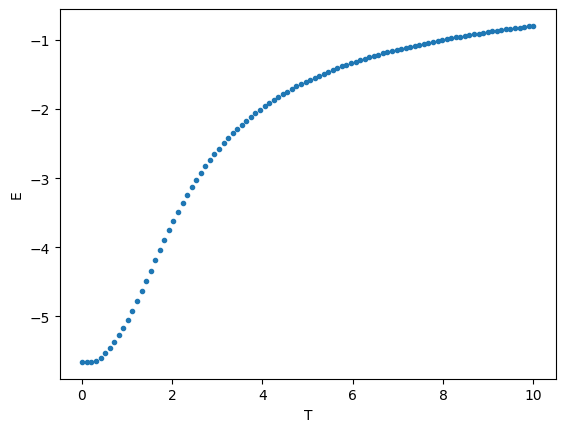

In [187]:
#수정사항! E = Tr(H@rho)와 rho = exp(-beta H) / Tr[exp(-beta H)] 를 이용해서 energy를 정확하게 계산해봤습니다

nr_qubits = 10
beta_list = [1/t for t in np.linspace(0.01,10,100)]
beta_list.sort()
exactenergy_list = []
for beta in beta_list:
    target_density_matrix = create_target(nr_qubits, beta, create_hamiltonian_matrix, interaction_graph)
    hamiltonian = create_hamiltonian_matrix(nr_qubits, interaction_graph)
    exactenergy = np.trace(hamiltonian@target_density_matrix)
    exactenergy_list.append(exactenergy)
    print(f"{beta} start", end=' ')
T = [1/beta for beta in beta_list]
plt.plot(T,exactenergy_list,'.')
plt.xlabel('T')
plt.ylabel('E')

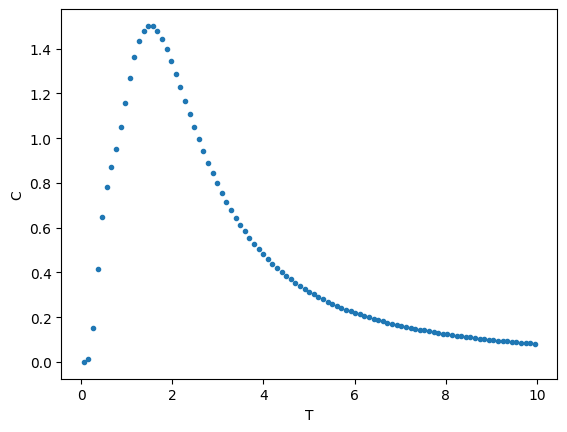

In [188]:
#수정사항! 위에서 matrix 연산을 통해 구한 E를 T에 대해 미분하여 열용량 C를 구하였습니다.

plt.plot((np.array(T)[1:] + T[:-1]) / 2, np.divide(np.diff(np.array(exactenergy_list)),np.diff(np.array(T))),'.')
# plt.xlim([0,2])
plt.xlabel('T')
plt.ylabel('C')
plt.show()

References
==========

1.  Verdon, G., Marks, J., Nanda, S., Leichenauer, S., & Hidary, J.
    (2019). Quantum Hamiltonian-Based Models and the Variational Quantum
    Thermalizer Algorithm. arXiv preprint
    [arXiv:1910.02071](https://arxiv.org/abs/1910.02071).

About the author
================
